In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as torchv
import numpy as np
import mymodels
import mycoco
import torchvision.transforms as transforms
import torch.utils.data as data
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
import os
import pdb

os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
print("Torch Version: {}".format(torch.__version__))
print("Cuda Available: {} \t device Count: {}".format(torch.cuda.is_available(), torch.cuda.device_count()))

Torch Version: 1.0.1.post2
Cuda Available: True 	 device Count: 2


In [3]:
BATCH_SIZE = 64
cuda = torch.cuda.is_available()

In [4]:
datasets

<module 'torchvision.datasets' from '/nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torchvision/datasets/__init__.py'>

In [5]:
mycoco.CocoDetection?

Init signature:
mycoco.CocoDetection(
    root,
    annFile,
    transform=None,
    target_transform=None,
    categories=None,
    batch_size=32,
)
Docstring:     
`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

Args:
    root (string): Root directory where images are downloaded to.
    annFile (string): Path to json annotation file.
    transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.ToTensor``
    target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
File:           /nfs/eecs-fserv/share/linzhe/CS535Proj/TestExamples/AutoEncoder/mycoco.py
Type:           type
Subclasses:     


In [6]:
def create_dataset(name='train', batch_size=32):
    dataDir='/scratch/cluster-share/linzhe/cocoDataset/'
    dataType='%s2017'%name
    annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
    root = '%s%s'%(dataDir, dataType)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    trans = transforms.Compose([transforms.Resize((28, 28)),
                                transforms.ToTensor()])
    target_transform = transforms.Compose([transforms.Resize((28, 28)),
                                           transforms.ToTensor()
                                           ]) # normalize to be in [-1, 1]
    coco = mycoco.CocoDetection(root, annFile, transform=trans, target_transform=target_transform, categories=['pizza'])
    cocoloader = data.DataLoader(coco, batch_size, num_workers=4, shuffle=True)
    
    return cocoloader, coco

In [7]:
cocoloader, cocoDataset = create_dataset(name='train', batch_size=BATCH_SIZE)

loading annotations into memory...
Done (t=16.14s)
creating index...
index created!


In [8]:
# check that there exist 10 different classes
np.unique(cocoDataset.categories)

array(['pizza'], dtype='<U5')

torch.Size([64, 3, 28, 28])
(28, 28, 3)


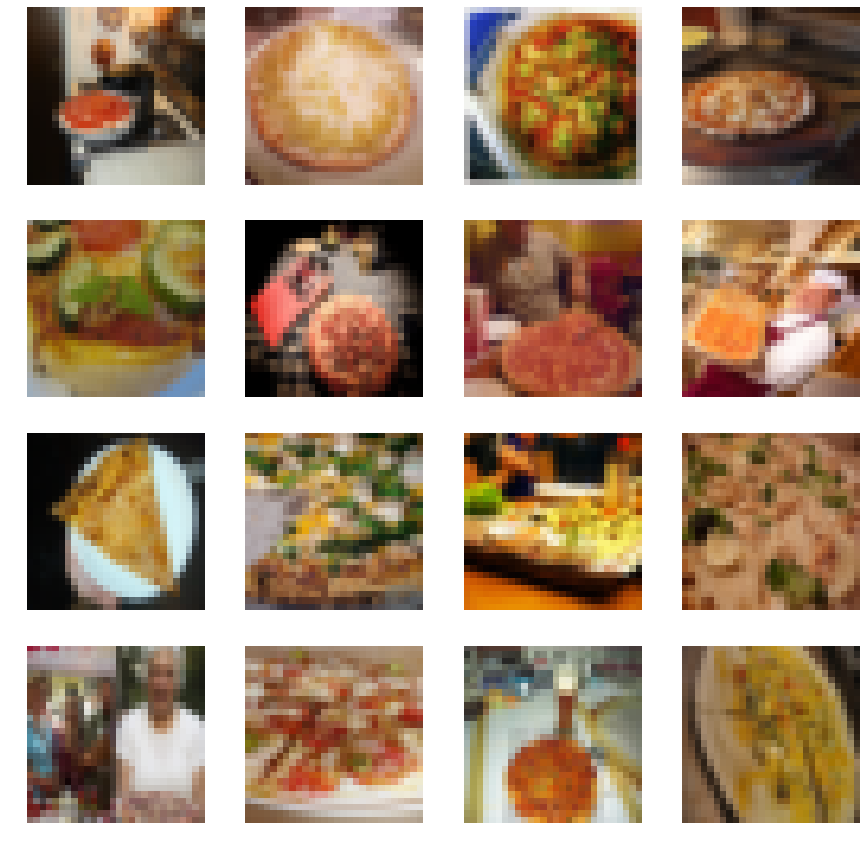

In [9]:
for im, mask in cocoloader:
    print(im.shape)
    print(np.swapaxes(np.swapaxes(im[0].numpy(),0,1),1,2).shape)
    break
    


f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask in  cocoloader:
#     print(im.shape)
    for image in im:
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(image.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break

173.8549
281.72943
399.17255
190.62355
445.92938
385.58038
136.95294
381.7608
58.54118
557.5529
654.23914
684.61957
186.81567
192.7804
377.1294
60.98824


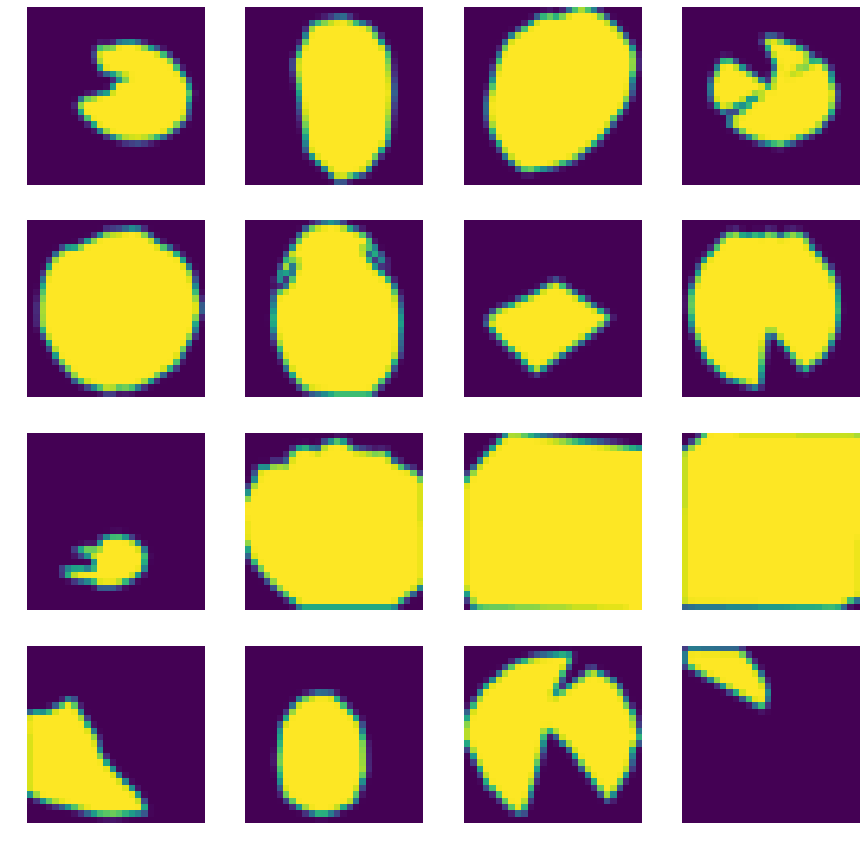

In [10]:

f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask in  cocoloader:
    
    for image in mask:
        print(np.sum(image.numpy()[0]))
#         print(image.numpy()[0])
#         print(image.numpy()[0].shape)
        axarr[i, j].imshow(image.numpy()[0])
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break
    

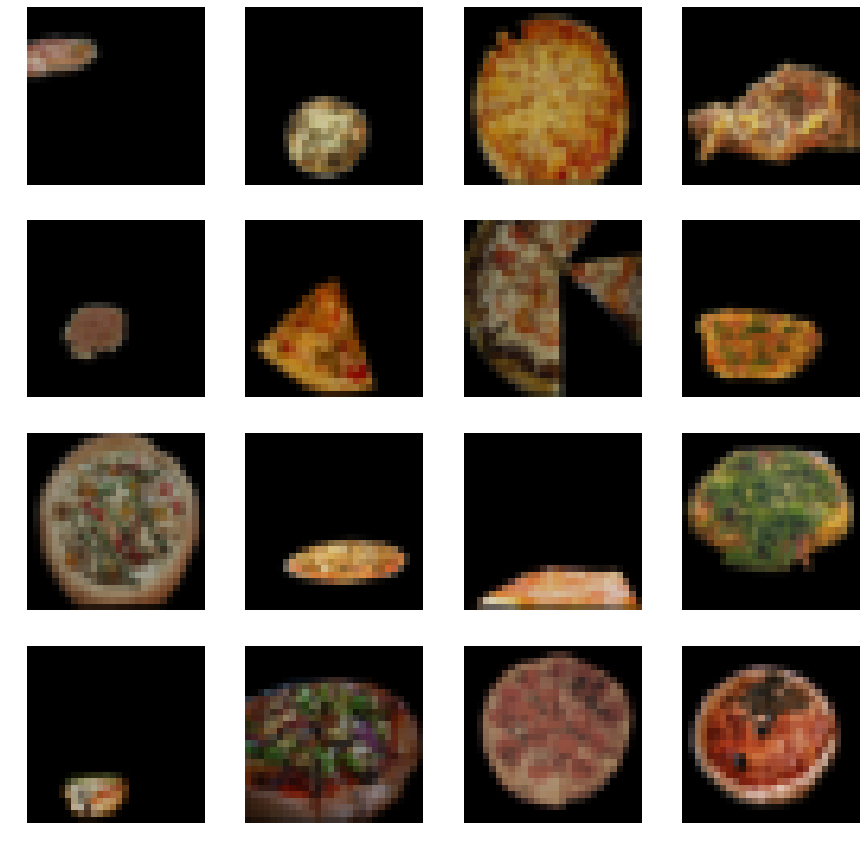

In [11]:
f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask in  cocoloader:
    im = np.multiply(im,mask)
#     print(im.shape)
    for image in im:
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(image.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break

In [12]:

data_loader = cocoloader
# pin_memory if you're on GPU

In [13]:
from torch import nn

In [14]:
n_batches = int(np.ceil(len(cocoDataset)/ BATCH_SIZE)) # 60000 / 100

In [15]:
n_batches

34

In [171]:
class DAE(nn.Module):
    def __init__(self):
        super(DAE, self).__init__()

        self.image_dim = 28 # a 28x28 image corresponds to 4 on the FC layer, a 64x64 image corresponds to 13
                            # can calculate this using output_after_conv() in utils.py
        self.latent_dim = 100
        self.noise_scale = 0
        self.batch_size = 50
        '''
        self.l1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=1),
            nn.ReLU())
        self.l2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=4, stride=1),
            nn.ReLU())
        self.l3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=4, stride=2),
            nn.ReLU())
        self.l4 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=4, stride=2),
            nn.ReLU())
        self.fc1 = nn.Linear(32*4*4, self.latent_dim)
        self.fc2 = nn.Linear(self.latent_dim, 32*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=1))
        '''
        self.l1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.l2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.l3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU())
        self.l4 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU())
        self.fc1 = nn.Linear(32*7*7, self.latent_dim)
        self.fc2 = nn.Linear(self.latent_dim, 32*7*7)
        self.decoder_l1 = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding = 1),
            nn.ReLU())
        #self.m1 = nn.MaxPool2d(3, stride=2)
        self.decoder_l2 = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding = 1),
            nn.ReLU())
        #self.m1 = nn.MaxPool2d(3, stride=2)
        self.decoder_l3 = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        #self.m1 = nn.MaxPool2d(3, stride=2)
        self.decoder_l4 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1))
	    #nn.Sigmoid())

    def forward(self, x):
        n = x.size()[0]
        if cuda:
            noise =  Variable(self.noise_scale*torch.randn(n, 1, self.image_dim, self.image_dim)).cuda()
        else:
            noise = Variable(self.noise_scale * torch.randn(n, 1, self.image_dim, self.image_dim))

        #x = torch.add(x, noise)
        #print("****")
        #print(x.shape)
        x = self.l1(x)
        #print(x.shape)
        x = self.l2(x)
        #print(x.shape)
        x = self.l3(x)
        #print(x.shape)
        z = self.l4(x)
        #print(x.shape)
        #z = self.encoder(x)
        z = z.view(-1, 32*7*7)
        z = self.fc1(z)
        x_hat = self.fc2(z)
        x_hat = x_hat.view(-1, 32, 7, 7)
        
        #print(x_hat.shape)
        x_hat = self.decoder_l1(x_hat)
        #print(x_hat.shape)
        x_hat = self.decoder_l2(x_hat)
        #print(x_hat.shape)
        x_hat = self.decoder_l3(x_hat)
        #print(x_hat.shape)
        x_hat = self.decoder_l4(x_hat)
        return z, x_hat

    def encode(self, x):
        #x = x.unsqueeze(0)
        z, x_hat = self.forward(x)

        return z

In [172]:
n_batches


34

In [173]:
dae = DAE()
if cuda:
    dae.cuda()
num_epochs = 200
dae.batch_size = BATCH_SIZE
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(dae.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for i, (images, masks) in enumerate(cocoloader):
        images = np.multiply(images,masks)
        if cuda:
            x = Variable(images).cuda()
        else:
            x = Variable(images)

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        z, x_hat = dae(x)
        #print(x.shape, x_hat.shape)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        '''
        if (i + 1) % 1 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, loss.data[0]))
            torch.save(dae.state_dict(), 'dae-test-model.pkl')
        '''
        if (i + 1) % 30 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                  %(epoch,
                    num_epochs,
                    i + 1,
                    n_batches,
                    loss.data,
                    loss.data,
                    0,
                    0)
            )

    # Save real images once
#     import pdb
#     pdb.set_trace()
    if (epoch + 1) == 1:
        images = images.view(images.size(0), 3, 28, 28) # reshape
        save_image(images.data, './data/real_images.png')
    fake_images = x_hat
    # Save sampled images
    #import pdb
    #pdb.set_trace()
    #fake_images = fake_images.view(fake_images.size(0), 3, 28, 28) #reshape
    #print(x_hat[0])
    #print(x_hat[0])
    save_image(fake_images.data, './data/fake_images-%0.3d.png' %(epoch + 1))

    # Save the trained parameters 
    torch.save(dae.state_dict(), './weights/dae-%0.3d.pkl' %(epoch + 1))
#     torch.save(D.state_dict(), './weights/discriminator-%0.3d.pkl' %(epoch + 1))
        

Epoch [0/200], Step[30/34], d_loss: 0.0247, g_loss: 0.0247, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1/200], Step[30/34], d_loss: 0.0116, g_loss: 0.0116, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2/200], Step[30/34], d_loss: 0.0103, g_loss: 0.0103, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3/200], Step[30/34], d_loss: 0.0105, g_loss: 0.0105, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4/200], Step[30/34], d_loss: 0.0077, g_loss: 0.0077, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [5/200], Step[30/34], d_loss: 0.0079, g_loss: 0.0079, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [6/200], Step[30/34], d_loss: 0.0075, g_loss: 0.0075, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [7/200], Step[30/34], d_loss: 0.0063, g_loss: 0.0063, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [8/200], Step[30/34], d_loss: 0.0058, g_loss: 0.0058, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [9/200], Step[30/34], d_loss: 0.0070, g_loss: 0.0070, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [10/200], Step[30/34], d_loss: 0.0